@Author: Sushant Das
@Date: 10-10-2024
@Last Modified by: Sushant Das
@Last Modified time: 10-10-2024
@Title: Based on bank customer data, predicted whether cutomer will subscribe to term
deposit or not

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split 

from imblearn.over_sampling import SMOTE

#### Loading the dataset

In [3]:
bank_df = pd.read_csv("datasets/bank.csv", delimiter=";")
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
(bank_df['y'] == 'yes').sum()

521

#### Analyzing the data

In [5]:
bank_df.shape

(4521, 17)

In [6]:
bank_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


#### Checking for null values

In [7]:
print(bank_df.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [8]:
col_list=list(bank_df.columns)

In [9]:
col_list.remove('y')
col_list

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

#### Checking for data outliers

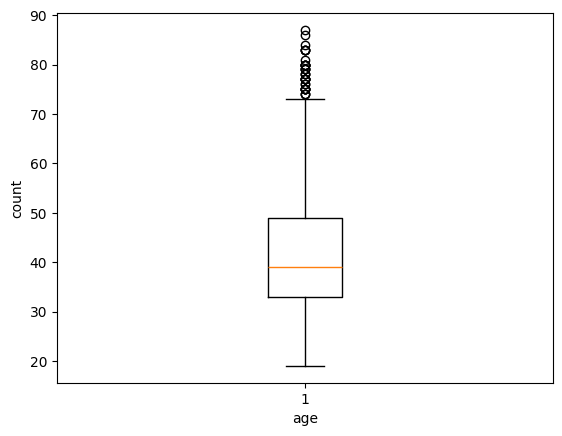

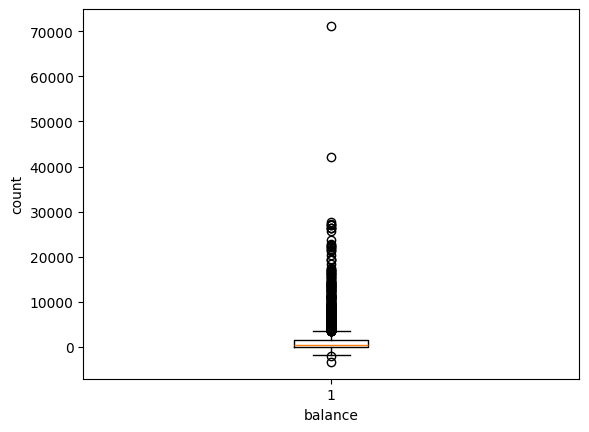

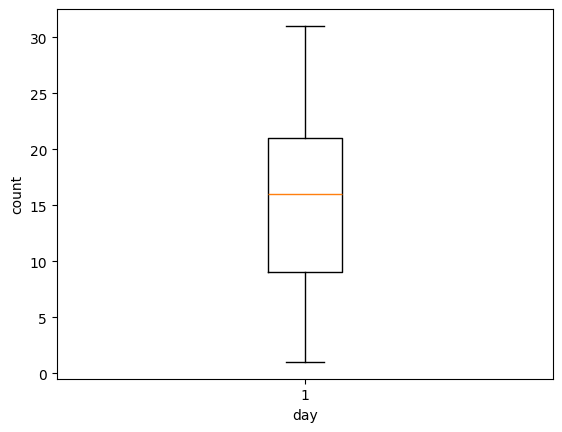

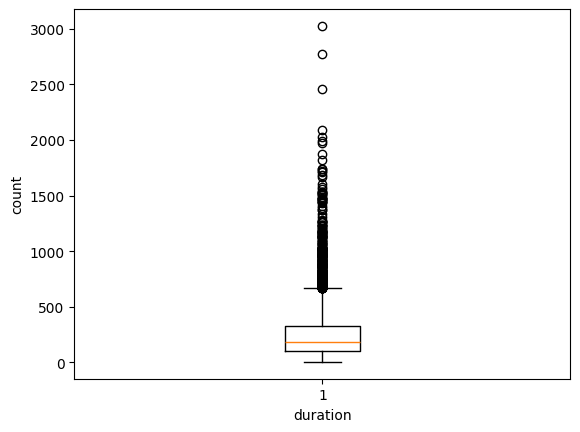

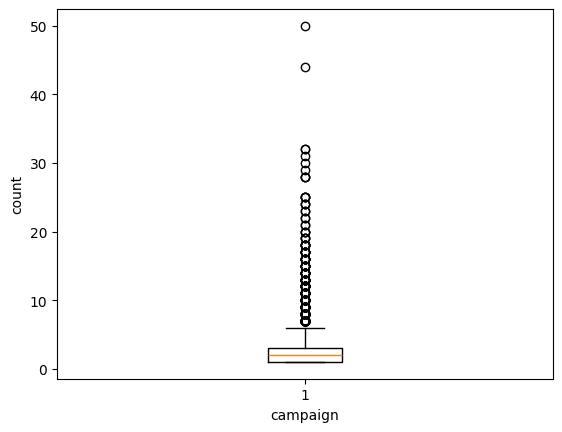

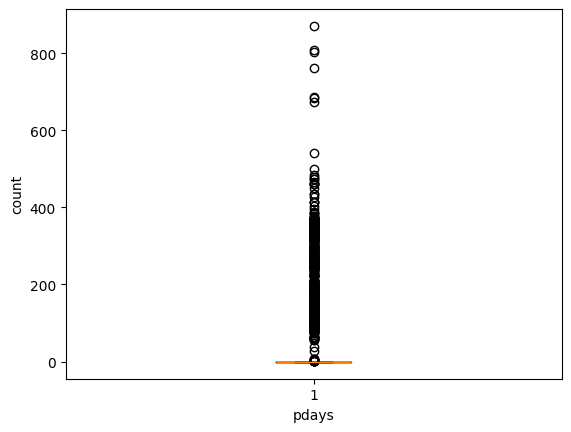

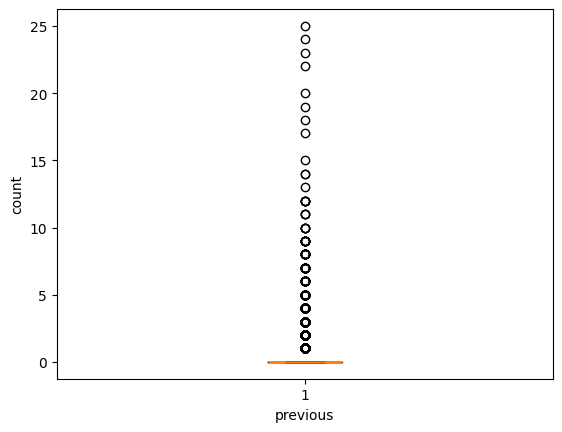

In [10]:
for i in col_list:
    if bank_df[i].dtypes==object:
        pass
    else:
        plt.boxplot(bank_df[i])
        plt.xlabel(i)
        plt.ylabel('count')
        plt.show()

#### Treating the data outliers

In [11]:
numeric_cols = bank_df.select_dtypes(include=['number'])

q1 = numeric_cols.quantile(0.25)
q3 = numeric_cols.quantile(0.75)
iqr = q3 - q1

print(iqr)

age           16.0
balance     1411.0
day           12.0
duration     225.0
campaign       2.0
pdays          0.0
previous       0.0
dtype: float64


In [12]:
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outlier_mask = (numeric_cols < lower_bound) | (numeric_cols > upper_bound)

# Filter the DataFrame to remove rows with any outliers
bank_df = bank_df[~outlier_mask.any(axis=1)]

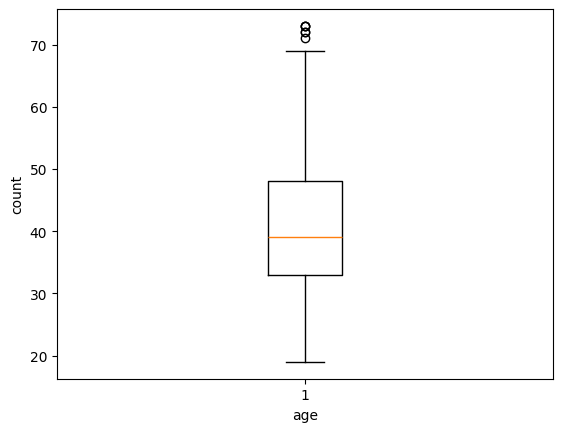

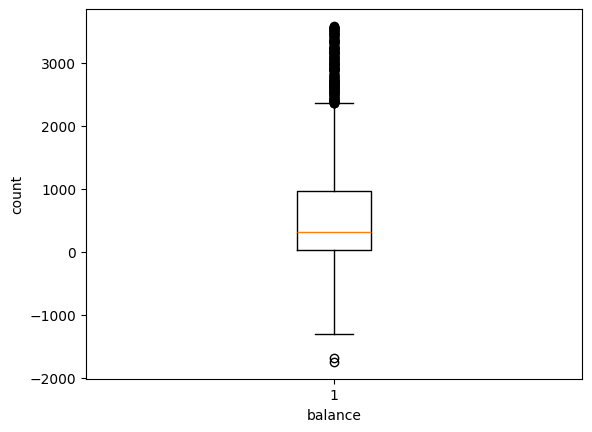

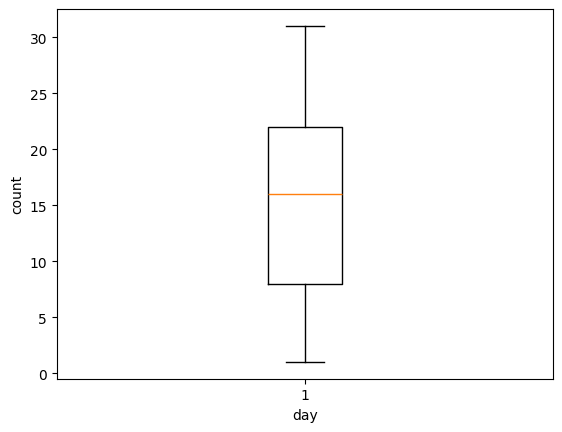

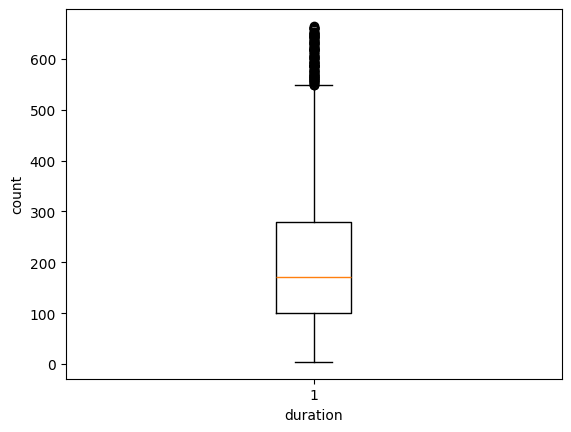

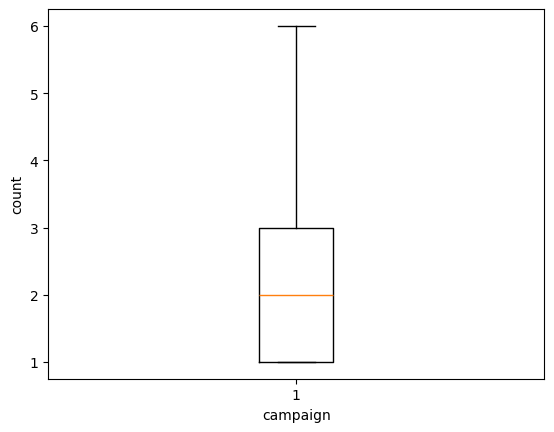

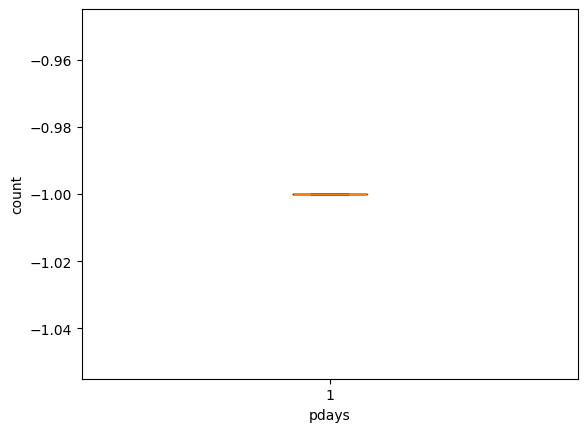

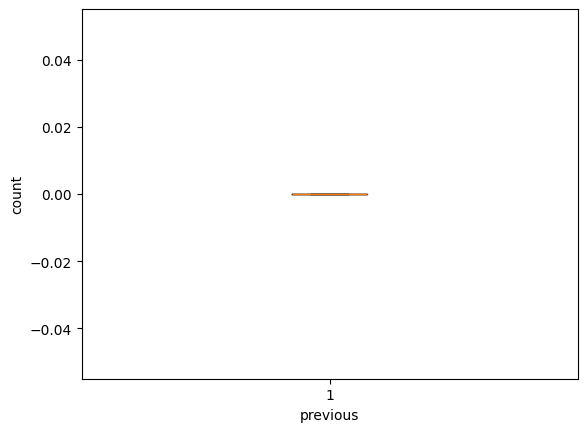

In [13]:
for i in col_list:
    if bank_df[i].dtypes==object:
        pass
    else:
        plt.boxplot(bank_df[i])
        plt.xlabel(i)
        plt.ylabel('count')
        plt.show()


In [14]:
bank_df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

#### Performing label encoding

In [15]:
col_list=[]
for i in bank_df.columns:
    if((bank_df[i].dtypes=='object')&(i!='y')):
        col_list.append(i)

In [16]:
col_list

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [17]:
labelencoder=LabelEncoder()

In [18]:
for i in col_list:
    bank_df[i]=labelencoder.fit_transform(bank_df[i])

In [19]:
bank_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,0,no
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,0,no
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,0,no
7,39,9,1,1,0,147,1,0,0,6,8,151,2,-1,0,0,no
8,41,2,1,2,0,221,1,0,2,14,8,57,2,-1,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4510,36,9,0,1,0,566,1,0,2,20,8,129,2,-1,0,0,no
4512,40,1,1,1,0,1100,1,0,2,29,8,660,2,-1,0,0,no
4513,49,1,1,1,0,322,0,0,0,14,1,356,2,-1,0,0,no
4515,32,7,2,1,0,473,1,0,0,7,5,624,5,-1,0,0,no


#### Plotting heatmap

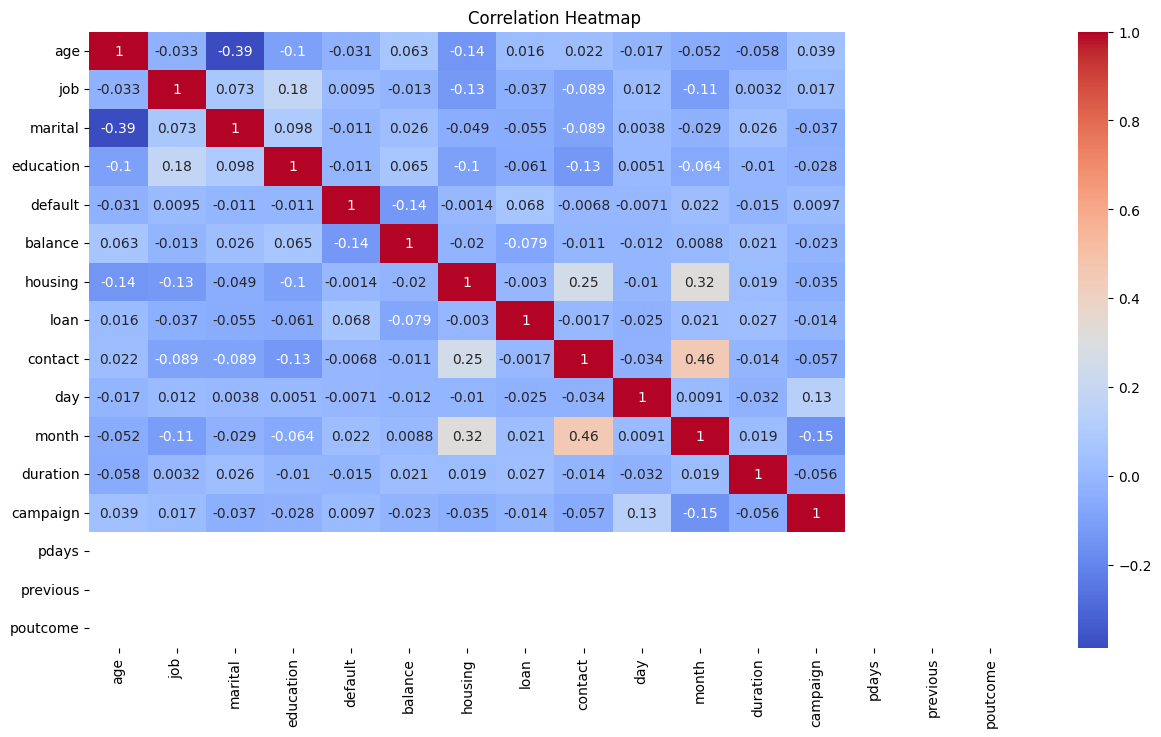

In [20]:
numeric_cols = bank_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Create the heatmap
fig = plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

#### Splitting the dataset

In [21]:
x = bank_df.drop(columns=['y'])
y = bank_df['y']

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=42)

#### Standardizing the data

In [23]:
from sklearn.preprocessing import StandardScaler    
st_x= StandardScaler()    
x_train= st_x.fit_transform(x_train)    
x_test= st_x.transform(x_test)  

In [24]:
x_train

array([[-0.87211774, -0.14740958,  1.44017521, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.63737349,  0.1563517 , -0.2319495 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.07266009, -0.14740958,  1.44017521, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.63466171, -0.14740958, -0.2319495 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.77184656, -0.14740958, -0.2319495 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.77184656,  1.37139682,  1.44017521, ...,  0.        ,
         0.        ,  0.        ]])

#### Training the model

In [25]:
from sklearn.neighbors import KNeighborsClassifier  
classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
classifier.fit(x_train, y_train)  

KNeighborsClassifier()

#### Testing the model

In [26]:
y_pred= classifier.predict(x_test)  

#### Checking the accuracy

In [27]:
from sklearn.metrics import confusion_matrix  
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.946524064171123


In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[531   2]
 [ 28   0]]


In [29]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

          no       0.95      1.00      0.97       533
         yes       0.00      0.00      0.00        28

    accuracy                           0.95       561
   macro avg       0.47      0.50      0.49       561
weighted avg       0.90      0.95      0.92       561

